In [1]:
# package
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import seasonal_plot
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from matplotlib import pyplot

from numpy import sqrt
from datetime import datetime, timedelta,date
from sklearn.metrics import mean_squared_error
#importing machine learning libraries
import pickle
import gc # to free some space from the memory
from sklearn.model_selection import KFold

import statsmodels.api as sm
import itertools

import warnings
warnings.filterwarnings("ignore")

#importing regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from xgboost import plot_importance
from lightgbm import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
import re

from sklearn.feature_selection import SelectFromModel

In [2]:
df1 = pd.read_csv(r"D:\HSC\WinterPressuresSource.csv")
# removing 1st row(blank row) and droping the missing DOI from the data set found 61 missing.
df1 = df1.drop(index=0)
df1 = df1.dropna(subset=["Date of Incident"])

In [3]:
df = df1.copy()
df = df.fillna('') # Replace NaN with blank

In [4]:
import re
import pandas as pd

def detect_date_format(date_str):
    formats = [
        r'\d{2}/\d{2}/\d{4}',  # dd/mm/yyyy
        r'\d{4}/\d{2}/\d{2}',  # yyyy/mm/dd
        r'\d{4}-\d{2}-\d{2}',  # yyyy-mm-dd
        r'\d{2}-\d{2}-\d{4}'   # dd-mm-yyyy
    ]
    for format_str in formats:
        if re.match(format_str, date_str):
            return format_str
    return None

def convert_date_format(date_str):
    detected_format = detect_date_format(date_str)
    if detected_format:
        if '/' in detected_format:
            parts = date_str.split('/')
        else:
            parts = date_str.split('-')
        if len(parts[0]) == 4:  # yyyy/mm/dd format
            return f"{parts[2]}/{parts[1]}/{parts[0]}"
        else:  # dd/mm/yyyy or yyyy-mm-dd format
            return date_str
    else:
        return None

# Apply conversion to the "Arrival Date" column
df["Date of Incident"] = df["Date of Incident"].apply(convert_date_format)
df["Arrival Date"] = df["Arrival Date"].apply(convert_date_format)
df["Ambulance Arrival Date"] = df["Ambulance Arrival Date"].apply(convert_date_format)
df["Ambulance Handover Date"] = df["Ambulance Handover Date"].apply(convert_date_format)
df["Triage Date"] = df["Triage Date"].apply(convert_date_format)
df["First Clinician Date"] = df["First Clinician Date"].apply(convert_date_format)
df["Decision to Admit Date"] = df["Decision to Admit Date"].apply(convert_date_format)
df["Date to Ward"] = df["Date to Ward"].apply(convert_date_format)
df["Left Dept Date"] = df["Left Dept Date"].apply(convert_date_format)

In [5]:
df["Date of Incident"] = pd.to_datetime(df["Date of Incident"])
df["Date of Incident"] = pd.to_datetime(df["Date of Incident"], format="%Y-%d-%m %H:%M:%S")
# Assuming 'df' is your DataFrame
df['Time of Incident'] = pd.to_datetime(df['Time of Incident'], errors='coerce').dt.time

# Assuming 'df' is your DataFrame
df['Date of Incident'] = pd.to_datetime(df['Date of Incident'])
df['Time of Incident'] = pd.to_timedelta(df['Time of Incident'].astype(str))

# Combine 'Date of Incident' and 'Time of Incident' into a new column 'incident_date_time'
df['incident_date_time'] = df['Date of Incident'] + df['Time of Incident']

# Drop the 'Time of Incident' column
df.drop('Time of Incident', axis=1, inplace=True)

In [9]:
# Assuming 'df' is your DataFrame
df['Ambulance Arrival Date'] = pd.to_datetime(df['Ambulance Arrival Date'],format="%d/%m/%Y")
df['Ambulance Arrival Time'] = pd.to_datetime(df['Ambulance Arrival Time'], errors='coerce').dt.time

# Combine 'Ambulance Arrival Date' and 'Ambulance Arrival Time' into a new column 'Ambulance Arrival Date Time'
df['Ambulance_Arrival_Date_Time'] = df['Ambulance Arrival Date'] + pd.to_timedelta(df['Ambulance Arrival Time'].astype(str))

# Drop the 'Ambulance Arrival Date' and 'Ambulance Arrival Time' columns if needed
df.drop(['Ambulance Arrival Time'], axis=1, inplace=True)

In [7]:
# Assuming 'df' is your DataFrame
df['Ambulance Handover Date'] = pd.to_datetime(df['Ambulance Handover Date'],format="%d/%m/%Y")
df['Ambulance Handover Time'] = pd.to_datetime(df['Ambulance Handover Time'], errors='coerce').dt.time

# Combine 'Ambulance Arrival Date' and 'Ambulance Arrival Time' into a new column 'Ambulance Arrival Date Time'
df['Ambulance_Handover_Date_Time'] = df['Ambulance Handover Date'] + pd.to_timedelta(df['Ambulance Handover Time'].astype(str))

# Drop the 'Ambulance Arrival Date' and 'Ambulance Arrival Time' columns if needed
df.drop(['Ambulance Handover Time'], axis=1, inplace=True)

In [6]:
# Assuming 'df' is your DataFrame
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'],format="%d/%m/%Y")
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], errors='coerce').dt.time

# Combine 'Arrival Date' and 'Arrival Time' into a new column 'Arrival Date Time'
df['Arrival_Date_Time'] = df['Arrival Date'] + pd.to_timedelta(df['Arrival Time'].astype(str))

# Drop the 'Arrival Date' column if needed
df.drop('Arrival Time', axis=1, inplace=True)

In [9]:
df['Triage Date'] = pd.to_datetime(df['Triage Date'])

df['Triage Time'] = pd.to_datetime(df['Triage Time'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['Triage_Date_Time'] = df['Triage Date'] + pd.to_timedelta(df['Triage Time'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('Triage Time', axis=1, inplace=True)

In [10]:
df['First Clinician Date'] = pd.to_datetime(df['First Clinician Date'])
df['First Clinician Date'] = pd.to_datetime(df['First Clinician Date'], format="%Y-%d-%m %H:%M:%S")

df['First Clinician Time'] = pd.to_datetime(df['First Clinician Time'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['First_Clinician_Date_Time'] = df['First Clinician Date'] + pd.to_timedelta(df['First Clinician Time'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('First Clinician Time', axis=1, inplace=True)

In [11]:
df['Decision to Admit Date'] = pd.to_datetime(df['Decision to Admit Date'], errors='coerce')
df['Decision to Admit Time'] = pd.to_datetime(df['Decision to Admit Time'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['Decision_to_Admit_date_Time'] = df['Decision to Admit Date'] + pd.to_timedelta(df['Decision to Admit Time'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('Decision to Admit Time', axis=1, inplace=True)

In [12]:
df['Date to Ward'] = pd.to_datetime(df['Date to Ward'], errors='coerce')
df['Time to Ward'] = pd.to_datetime(df['Time to Ward'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['Date_to_Ward_DATE_Time'] = df['Date to Ward'] + pd.to_timedelta(df['Time to Ward'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('Time to Ward', axis=1, inplace=True)

In [13]:
# Convert 'Left Dept Date' to datetime format, handling incorrect date formats
df['Left Dept Date'] = pd.to_datetime(df['Left Dept Date'], errors='coerce', dayfirst=True)
# Convert 'Left Dept Time' to datetime.time format
df['Left Dept Time'] = pd.to_datetime(df['Left Dept Time'], errors='coerce').dt.time
# Combine 'Left Dept Date' and 'Left Dept Time' into a new column 'Left_Dept_Date_Time'
df['Left_Dept_Date_Time'] = df['Left Dept Date'] + pd.to_timedelta(df['Left Dept Time'].astype(str))

# Drop the 'Left Dept Time' column
df.drop('Left Dept Time', axis=1, inplace=True)

In [14]:
# Define the age ranges and corresponding labels
age_bins = [0, 18, 45, 55, 65, 75, 85, float('inf')]
age_labels = ['<18', '18-44', '45-54', '55-64', '65-74', '75-84', '85+']


# Convert the 'Age' column to numeric, replacing empty strings with NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop rows with missing 'Age' values
df.dropna(subset=['Age'], inplace=True)

# Convert 'Age' into categorical classes
df['Age_Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# 46 missing in Age were dropped
df.dropna(subset="Age_Category",inplace=True)

# # View the updated DataFrame with the 'Age_Category' column
# print(df[['Age', 'Age_Category']])

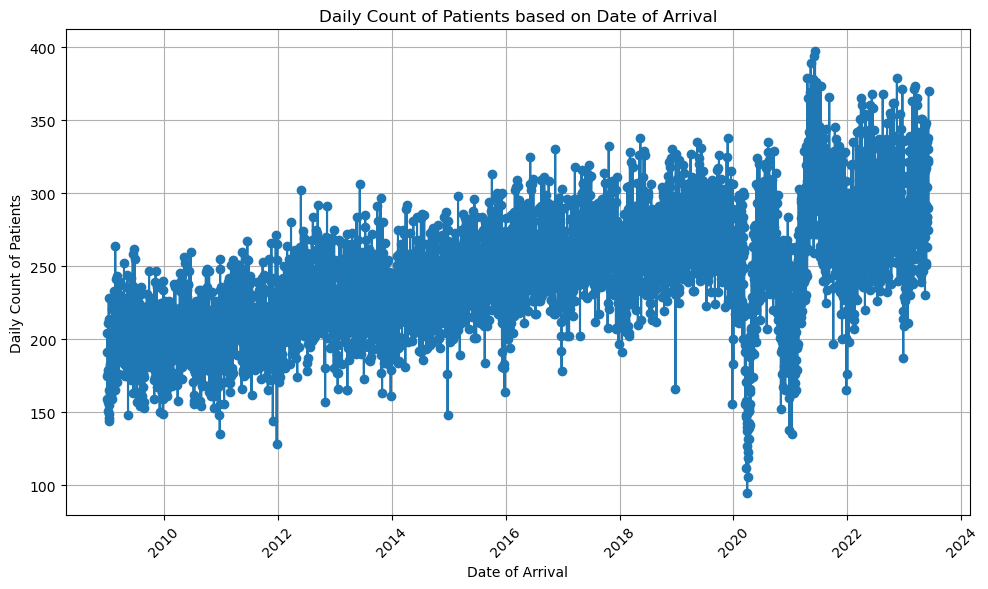

In [7]:
# Group by 'Date of Arrival' and calculate the daily count of patients
daily_patient_count = df.groupby('Arrival Date').size()

# Plot the daily count of patients
plt.figure(figsize=(10, 6))
plt.plot(daily_patient_count.index, daily_patient_count.values, marker='o', linestyle='-')
plt.xlabel('Date of Arrival')
plt.ylabel('Daily Count of Patients')
plt.title('Daily Count of Patients based on Date of Arrival')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Slicing the winter df

In [10]:
# Filter the DataFrame to keep only winter months (October to March)
df_winter_amp = df[df["Ambulance Arrival Date"].dt.month.isin([10, 11, 12, 1, 2, 3])]

In [11]:
# Filter the DataFrame to keep only winter months (October to March)
df_winter = df[df["Arrival Date"].dt.month.isin([10, 11, 12, 1, 2, 3])]

In [12]:
daily_patient_count = df_winter.groupby("Arrival Date").size().reset_index(name='Patient Count')

In [13]:
daily_patient_count

,Arrival Date,Patient Count
0,2009-01-01,191
1,2009-01-02,204
2,2009-01-03,175
3,2009-01-04,159
4,2009-01-05,179
...,...,...
2636,2023-03-27,342
2637,2023-03-28,324
2638,2023-03-29,313
2639,2023-03-30,310


In [14]:
daily_patient_count_amb = df_winter_amp.groupby("Ambulance Arrival Date").size().reset_index(name='Patient Count')

In [15]:
daily_patient_count_amb

,Ambulance Arrival Date,Patient Count
0,2009-01-01,52
1,2009-01-02,46
2,2009-01-03,41
3,2009-01-04,27
4,2009-01-05,44
...,...,...
2636,2023-03-27,44
2637,2023-03-28,39
2638,2023-03-29,44
2639,2023-03-30,31


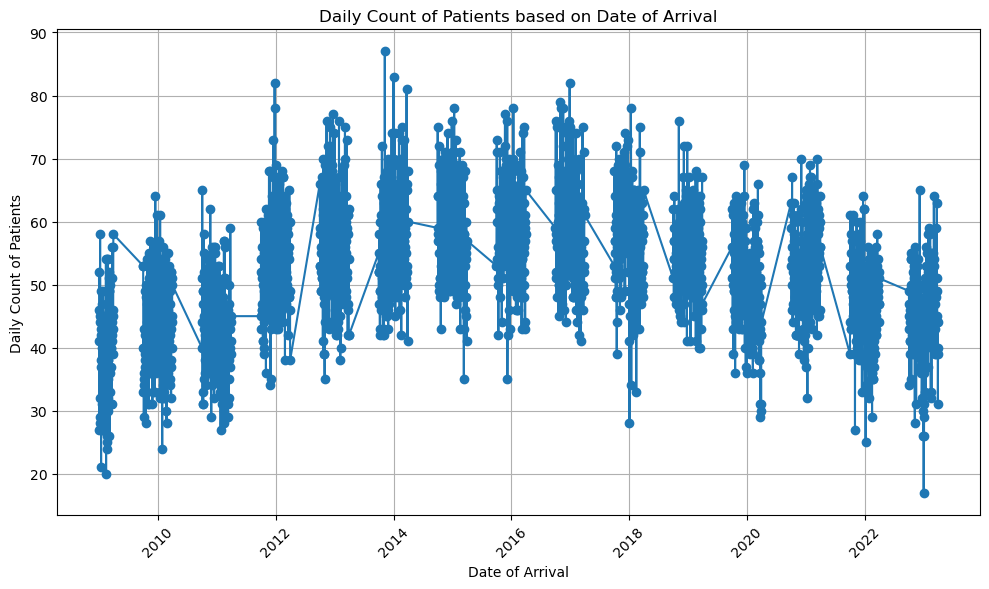

In [16]:
# Plot the daily count of patients
plt.figure(figsize=(10, 6))
plt.plot(daily_patient_count_amb["Ambulance Arrival Date"], daily_patient_count_amb["Patient Count"], marker='o', linestyle='-')
plt.xlabel('Date of Arrival')
plt.ylabel('Daily Count of Patients')
plt.title('Daily Count of Patients based on Date of Arrival')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Combining the Df

In [18]:
import pandas as pd

# Assuming you have two dataframes: daily_patient_count_amb and daily_patient_count

# Merge the dataframes based on Arrival Date
combined_df = pd.merge(daily_patient_count_amb, daily_patient_count, 
                       left_on='Ambulance Arrival Date', right_on='Arrival Date', 
                       how='inner')

# Rename columns as needed
combined_df.rename(columns={'Patient Count_x': 'Patient_Count_Amb', 'Patient Count_y': 'Patient Count'}, inplace=True)
# You can adjust the column names as per your actual dataframes

# Drop the duplicated Arrival Date column (since we have merged on it)
combined_df.drop('Ambulance Arrival Date', axis=1, inplace=True)
# You can adjust the column name if it's different in your actual dataframes

# Calculate the proportion of patients arrived using ambulance
combined_df['Proportion_Ambulance'] = (combined_df['Patient_Count_Amb'] / combined_df['Patient Count']) * 100

# Print the combined dataframe
combined_df

,Patient_Count_Amb,Arrival Date,Patient Count,Proportion_Ambulance
0,52,2009-01-01,191,27.225131
1,46,2009-01-02,204,22.549020
2,41,2009-01-03,175,23.428571
3,27,2009-01-04,159,16.981132
4,44,2009-01-05,179,24.581006
...,...,...,...,...
2636,44,2023-03-27,342,12.865497
2637,39,2023-03-28,324,12.037037
2638,44,2023-03-29,313,14.057508
2639,31,2023-03-30,310,10.000000


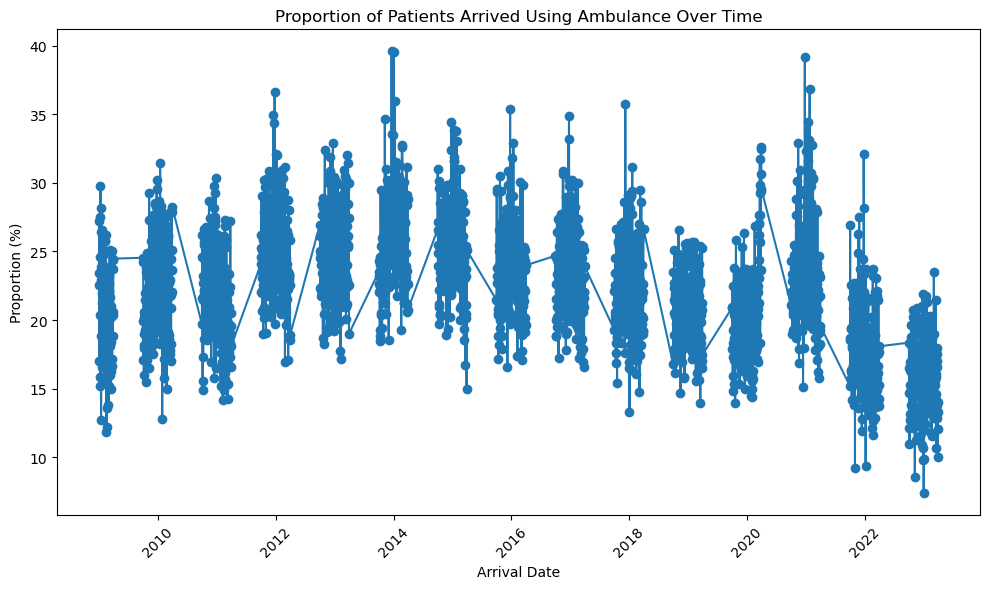

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already merged and calculated the proportion as shown before

# Plotting the time series graph
plt.figure(figsize=(10, 6))  # Set the figure size

# Use the Arrival Date as the x-axis and Proportion_Ambulance as the y-axis
plt.plot(combined_df['Arrival Date'], combined_df['Proportion_Ambulance'], marker='o')

# Set labels and title
plt.xlabel('Arrival Date')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Patients Arrived Using Ambulance Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd

# Assuming you have already merged and calculated the proportion as shown before

# Calculate the correlation between Patient_Count_Amb and Patient Count
correlation = combined_df['Patient_Count_Amb'].corr(combined_df['Patient Count'])

print(f"Correlation between Patient_Count_Amb and Patient Count: {correlation}")

Correlation between Patient_Count_Amb and Patient Count: 0.33082893722347306


### Daily Arrival Prediction

In [24]:
# Assuming winter_daily_patient_count is your DataFrame
combined_df = combined_df.set_index("Arrival Date")

# Create a new column 'Day of Week' containing the day of the week for each Arrival Date
combined_df["Day_of_Week"] = combined_df.index.day_name()

# Create a new column 'Month' containing the name of the month for each Arrival Date
combined_df["Month"] = combined_df.index.strftime('%B')

# Create a new column 'COVID Status' indicating whether the year is within the COVID-19 pandemic period
combined_df["COVID_Status"] = combined_df.index.map(lambda x: 'Yes' if 2019 <= x.year <= 2021 else 'No')

def get_season(arrival_date):
    year = arrival_date.year
    if arrival_date.month >= 10:
        season = f"{year} to {year + 1}"
    else:
        season = f"{year - 1} to {year}"
    return season

# Apply the get_season function to the "Arrival Date" column
combined_df["Season"] = combined_df.index.map(get_season)

In [26]:
# Create a new column "Is Weekend" indicating whether the date is a weekend
combined_df["Is Weekend"] = combined_df.index.map(lambda x: x.weekday() >= 5)

In [27]:
combined_df

,Patient_Count_Amb,Patient Count,Proportion_Ambulance,Day_of_Week,Month,COVID_Status,Season,Is Weekend
Arrival Date,,,,,,,,
2009-01-01,52,191,27.225131,Thursday,January,No,2008 to 2009,False
2009-01-02,46,204,22.549020,Friday,January,No,2008 to 2009,False
2009-01-03,41,175,23.428571,Saturday,January,No,2008 to 2009,True
2009-01-04,27,159,16.981132,Sunday,January,No,2008 to 2009,True
2009-01-05,44,179,24.581006,Monday,January,No,2008 to 2009,False
...,...,...,...,...,...,...,...,...
2023-03-27,44,342,12.865497,Monday,March,No,2022 to 2023,False
2023-03-28,39,324,12.037037,Tuesday,March,No,2022 to 2023,False
2023-03-29,44,313,14.057508,Wednesday,March,No,2022 to 2023,False


In [28]:
from sklearn.preprocessing import LabelEncoder
# Perform label encoding for 'Day of Week', 'Month', and 'COVID Status'
# You can also use one-hot encoding if you prefer

# Define custom mappings for day of the week and month
day_mapping = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6
}

month_mapping = {
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
}

weekend_mapping = {
    True: 0,
    False: 1
    
}

# Apply the custom mappings to 'Day of Week' and 'Month'
combined_df['Day_of_Week_Encoded'] = combined_df['Day_of_Week'].map(day_mapping)
combined_df['Month_Encoded'] = combined_df['Month'].map(month_mapping)
combined_df['Is_Weekend_Encoded'] = combined_df["Is Weekend"].map(weekend_mapping)

label_encodings = {}

for column in ['COVID_Status']:
    le = LabelEncoder()
    combined_df[column + '_Encoded'] = le.fit_transform(combined_df[column])
    label_encodings[column] = le.classes_

# Print the label encodings for reference
for column, classes in label_encodings.items():
    print(column, ":", classes)
    

COVID_Status : ['No' 'Yes']


In [29]:
combined_df

,Patient_Count_Amb,Patient Count,Proportion_Ambulance,Day_of_Week,Month,COVID_Status,Season,Is Weekend,Day_of_Week_Encoded,Month_Encoded,Is_Weekend_Encoded,COVID_Status_Encoded
Arrival Date,,,,,,,,,,,,
2009-01-01,52,191,27.225131,Thursday,January,No,2008 to 2009,False,4,0,1,0
2009-01-02,46,204,22.549020,Friday,January,No,2008 to 2009,False,5,0,1,0
2009-01-03,41,175,23.428571,Saturday,January,No,2008 to 2009,True,6,0,0,0
2009-01-04,27,159,16.981132,Sunday,January,No,2008 to 2009,True,0,0,0,0
2009-01-05,44,179,24.581006,Monday,January,No,2008 to 2009,False,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,44,342,12.865497,Monday,March,No,2022 to 2023,False,1,2,1,0
2023-03-28,39,324,12.037037,Tuesday,March,No,2022 to 2023,False,2,2,1,0
2023-03-29,44,313,14.057508,Wednesday,March,No,2022 to 2023,False,3,2,1,0


In [30]:
# Sample data for the "Season" column
seasons = ['2008 to 2009', '2009 to 2010', '2010 to 2011', '2011 to 2012',
           '2012 to 2013', '2013 to 2014', '2014 to 2015', '2015 to 2016',
           '2016 to 2017', '2017 to 2018', '2018 to 2019', '2019 to 2020',
           '2020 to 2021', '2021 to 2022', '2022 to 2023','2023 to 2024']
# Create a mapping of season labels to numerical values
season_to_num = {season: i for i, season in enumerate(seasons)}


# Apply the mapping to the "Season" column and add a new "Season_Num" column
combined_df["Season_Num"] = combined_df["Season"].map(season_to_num)

In [31]:
combined_df

,Patient_Count_Amb,Patient Count,Proportion_Ambulance,Day_of_Week,Month,COVID_Status,Season,Is Weekend,Day_of_Week_Encoded,Month_Encoded,Is_Weekend_Encoded,COVID_Status_Encoded,Season_Num
Arrival Date,,,,,,,,,,,,,
2009-01-01,52,191,27.225131,Thursday,January,No,2008 to 2009,False,4,0,1,0,0
2009-01-02,46,204,22.549020,Friday,January,No,2008 to 2009,False,5,0,1,0,0
2009-01-03,41,175,23.428571,Saturday,January,No,2008 to 2009,True,6,0,0,0,0
2009-01-04,27,159,16.981132,Sunday,January,No,2008 to 2009,True,0,0,0,0,0
2009-01-05,44,179,24.581006,Monday,January,No,2008 to 2009,False,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,44,342,12.865497,Monday,March,No,2022 to 2023,False,1,2,1,0,14
2023-03-28,39,324,12.037037,Tuesday,March,No,2022 to 2023,False,2,2,1,0,14
2023-03-29,44,313,14.057508,Wednesday,March,No,2022 to 2023,False,3,2,1,0,14


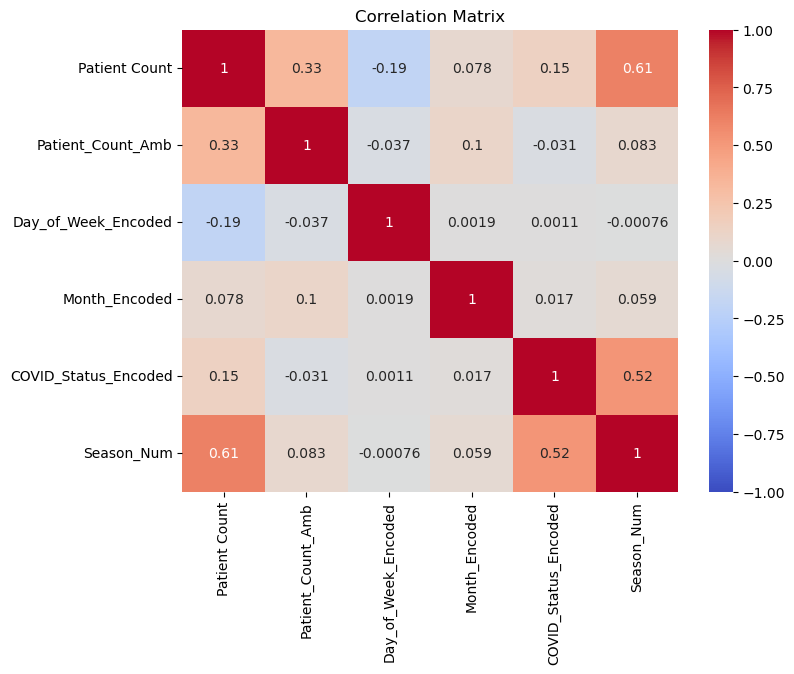

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# df = pd.read_csv('your_dataset.csv')

# ... Previous code for data preparation and encoding ...

# Select numeric columns for correlation analysis
numeric_columns = ['Patient Count','Patient_Count_Amb', 'Day_of_Week_Encoded', 'Month_Encoded', 'COVID_Status_Encoded','Season_Num']

# Calculate the correlation matrix
correlation_matrix = combined_df[numeric_columns].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Processed data for the model 

In [35]:
sea_df= combined_df[["Patient Count","Patient_Count_Amb","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]

In [36]:
sea_df

,Patient Count,Patient_Count_Amb,COVID_Status_Encoded,Month_Encoded,Day_of_Week_Encoded,Season_Num,Is_Weekend_Encoded
Arrival Date,,,,,,,
2009-01-01,191,52,0,0,4,0,1
2009-01-02,204,46,0,0,5,0,1
2009-01-03,175,41,0,0,6,0,0
2009-01-04,159,27,0,0,0,0,0
2009-01-05,179,44,0,0,1,0,1
...,...,...,...,...,...,...,...
2023-03-27,342,44,0,2,1,14,1
2023-03-28,324,39,0,2,2,14,1
2023-03-29,313,44,0,2,3,14,1


# XG boost

Mean Squared Error (MSE): 56.30883062940385
Mean Absolute Error (MAE): 5.846346192012559
Min Forecasting Error: 0.02194976806640625
Max Forecasting Error: 23.960933685302734
Mean Forecasting Error: 5.846346192012559
Standard Deviation: 4.719808676711489
R-squared (R2): 0.01819418426306152
Correlation: 0.20721143341196957


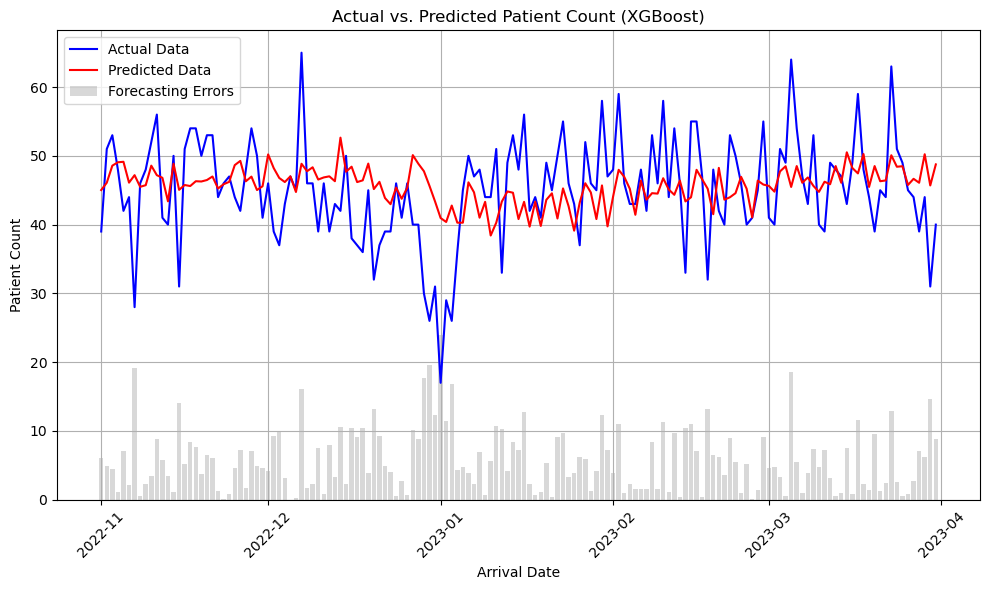

In [37]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test = test_data['Patient_Count_Amb']

# Fit an XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# ARIMA 

Mean Squared Error (MSE): 95.52306194962448
Mean Absolute Error (MAE): 7.761785296051874
Min Forecasting Error: 0.11444955252376587
Max Forecasting Error: 34.22005782250098
Mean Forecasting Error: 7.761785296051874
Standard Deviation: 5.959273107860402
R-squared (R2): -0.6655486663608252
Correlation: 0.06342541798157618


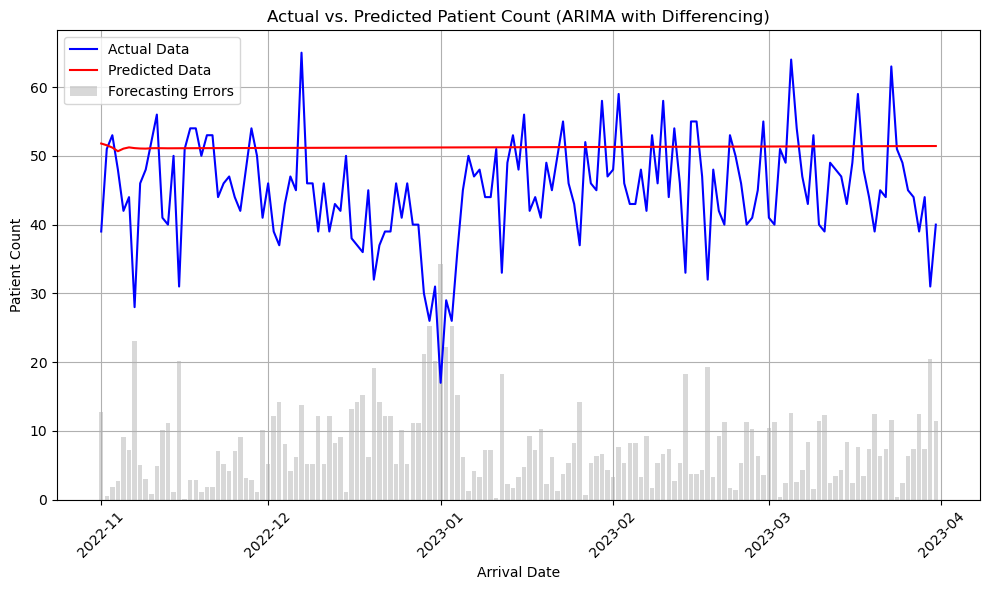

In [44]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract target variable
y_train = train_data['Patient_Count_Amb']
y_test = test_data['Patient_Count_Amb']

# Apply first-order differencing to make the data stationary
d = 1
y_train_diff = y_train.diff(periods=d).dropna()

# Fit an ARIMA model
order = (5, d, 2)  # (p, d, q)

model = ARIMA(y_train_diff, order=order)
model_fit = model.fit()

# Make predictions on the differenced scale
predictions_diff = model_fit.forecast(steps=len(y_test))

# Invert the differencing to get the original scale predictions
predictions = np.cumsum(predictions_diff) + y_train.iloc[-1]  # Adjusted for the last value of the original series

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (ARIMA with Differencing)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# SARIMAX

Mean Squared Error (MSE): 64.05316581078895
Mean Absolute Error (MAE): 6.360445359868845
Min Forecasting Error: 0.0037762647851451447
Max Forecasting Error: 23.73250463338467
Mean Forecasting Error: 6.360445359868845
Standard Deviation: 4.873932700856456
R-squared (R2): -0.11683673779855996
Correlation: 0.29058855630862757


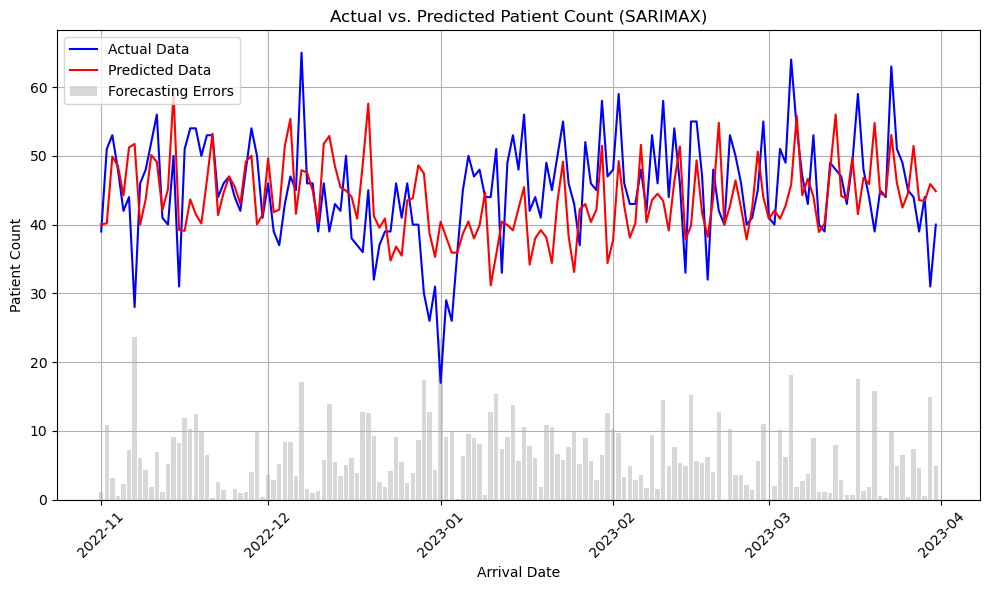

In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract target variable
y_train = train_data['Patient_Count_Amb']
y_test = test_data['Patient_Count_Amb']

# Extract exogenous variables
exog_cols = ["Patient Count", "COVID_Status_Encoded", "Month_Encoded", "Day_of_Week_Encoded", "Season_Num", "Is_Weekend_Encoded"]
X_train = train_data[exog_cols]
X_test = test_data[exog_cols]

# Fit a SARIMAX model
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 7)  # (P, D, Q, S) Adjust S as needed

model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Make predictions
predictions = model_fit.forecast(steps=len(y_test), exog=X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (SARIMAX)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Regression

Mean Squared Error (MSE): 262.57609375717044
Mean Absolute Error (MAE): 14.372171957051588
Min Forecasting Error: 0.2806334017456038
Max Forecasting Error: 36.35077195154891
Mean Forecasting Error: 14.372171957051588
Standard Deviation: 7.509341656057774
R-squared (R2): -3.578300295756061
Correlation: 0.26557034414540337


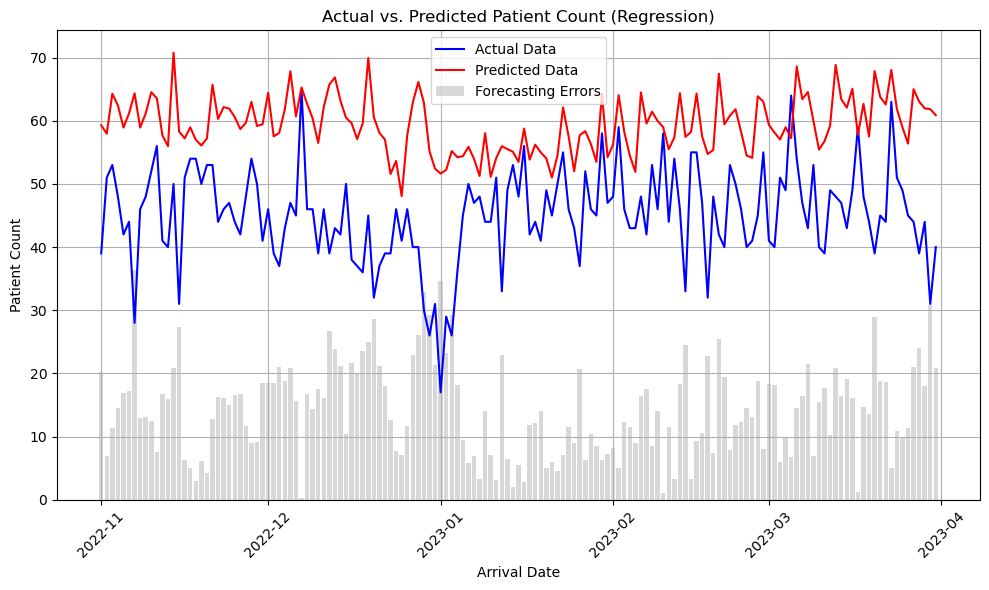

In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test = test_data['Patient_Count_Amb']

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (Regression)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# polynomal regresion

Mean Squared Error (MSE): 64.5478866228137
Mean Absolute Error (MAE): 6.447541741721434
Min Forecasting Error: 0.04822386103261067
Max Forecasting Error: 24.42431489198171
Mean Forecasting Error: 6.447541741721434
Standard Deviation: 4.809394216078633
R-squared (R2): -0.12546273420059428
Correlation: 0.16750374124153347


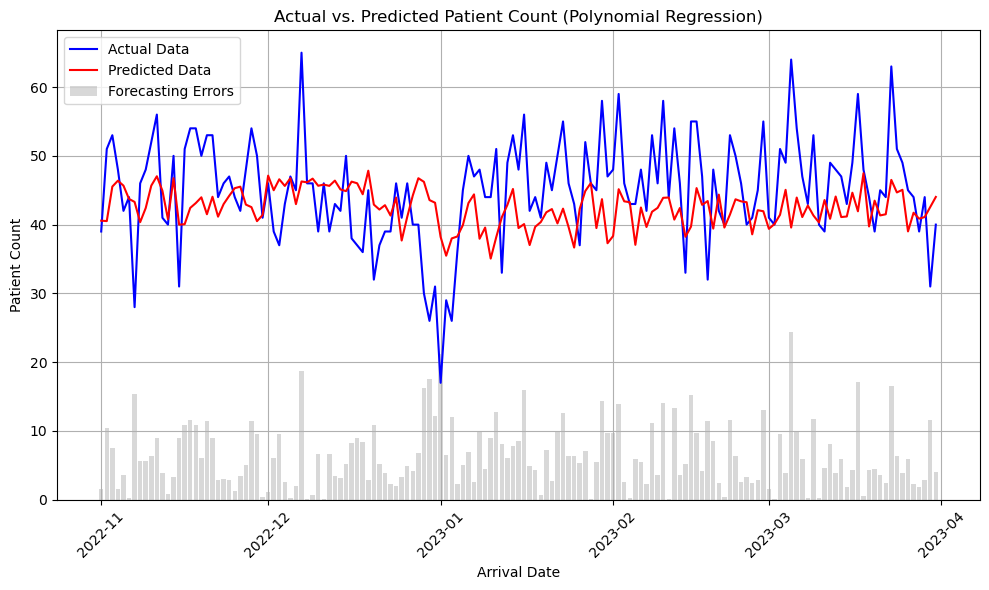

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test = test_data['Patient_Count_Amb']


# Apply Polynomial Features
poly = PolynomialFeatures(degree=2)  # You can adjust the degree
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {'alpha': [0.1, 1, 10]}
model = Ridge()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)

best_model = grid_search.best_estimator_

# Make predictions using the best model
best_predictions = best_model.predict(X_test_poly)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': best_predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])  # Calculate correlation

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)  # Print correlation

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (Polynomial Regression)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# XG boost

In [62]:
import pandas as pd
import xgboost as xgb

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'

train_data = sea_df[train_start:train_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Access feature importance scores
feature_importance = xgb_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
4            Season_Num    0.507223
0         Patient Count    0.234388
1  COVID_Status_Encoded    0.085773
2         Month_Encoded    0.077125
3   Day_of_Week_Encoded    0.049621
5    Is_Weekend_Encoded    0.045868


Mean Squared Error (MSE): 56.30883062940385
Mean Absolute Error (MAE): 5.846346192012559
Min Forecasting Error: 0.02194976806640625
Max Forecasting Error: 23.960933685302734
Mean Forecasting Error: 5.846346192012559
Standard Deviation: 4.719808676711489
R-squared (R2): 0.01819418426306152
Correlation: 0.20721143341196957


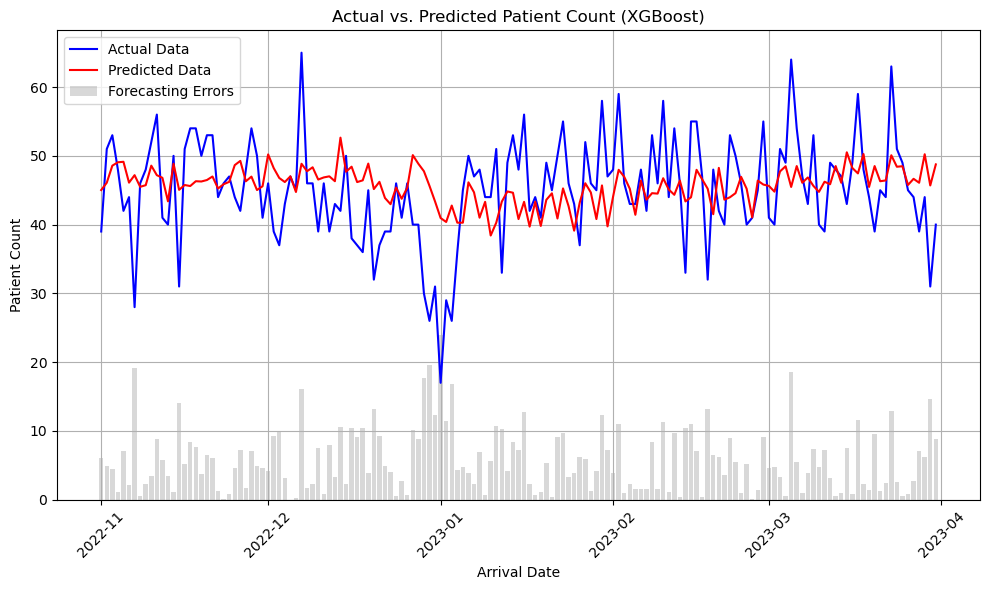

In [49]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test = test_data['Patient_Count_Amb']


# Fit an XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mean Squared Error (MSE): 55.24655443891705
Mean Absolute Error (MAE): 5.847104937824982
Min Forecasting Error: 0.009204864501953125
Max Forecasting Error: 22.47496795654297
Mean Forecasting Error: 5.847104937824982
Standard Deviation: 4.604161639960052
R-squared (R2): 0.036716127093005535
Correlation: 0.24080004375527705


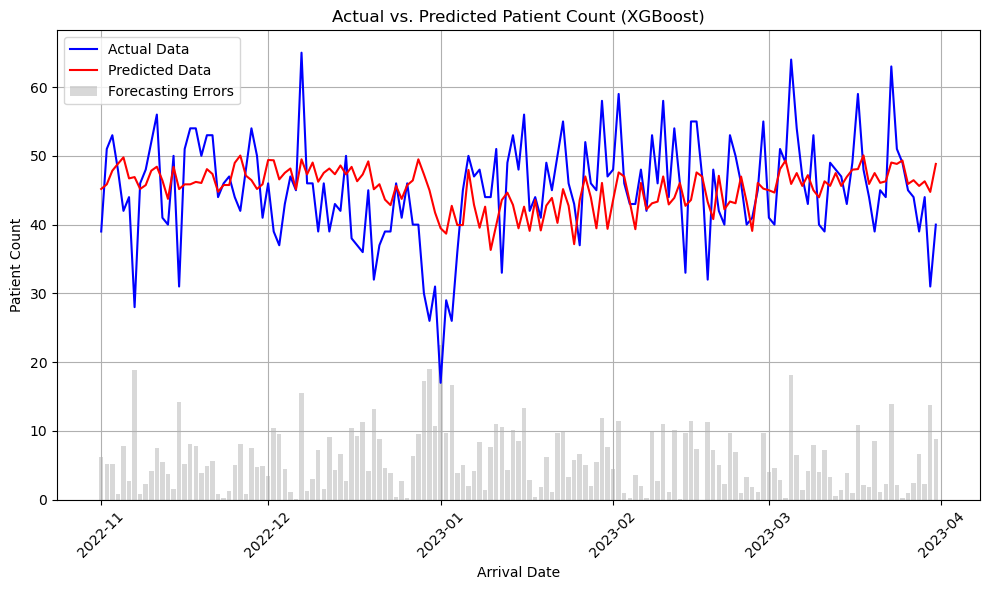

In [59]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test = test_data['Patient_Count_Amb']

# Set up parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize XGBoost model
model = XGBRegressor()

# Create GridSearchCV instance
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions using the best model
predictions = best_model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mean Squared Error (MSE): 55.71491158239951
Mean Absolute Error (MAE): 5.723412898992071
Min Forecasting Error: 0.025913238525390625
Max Forecasting Error: 25.023113250732422
Mean Forecasting Error: 5.723412898992071
Standard Deviation: 4.8073387730827095
R-squared (R2): 0.02854980997767731
Correlation: 0.20695223079281735


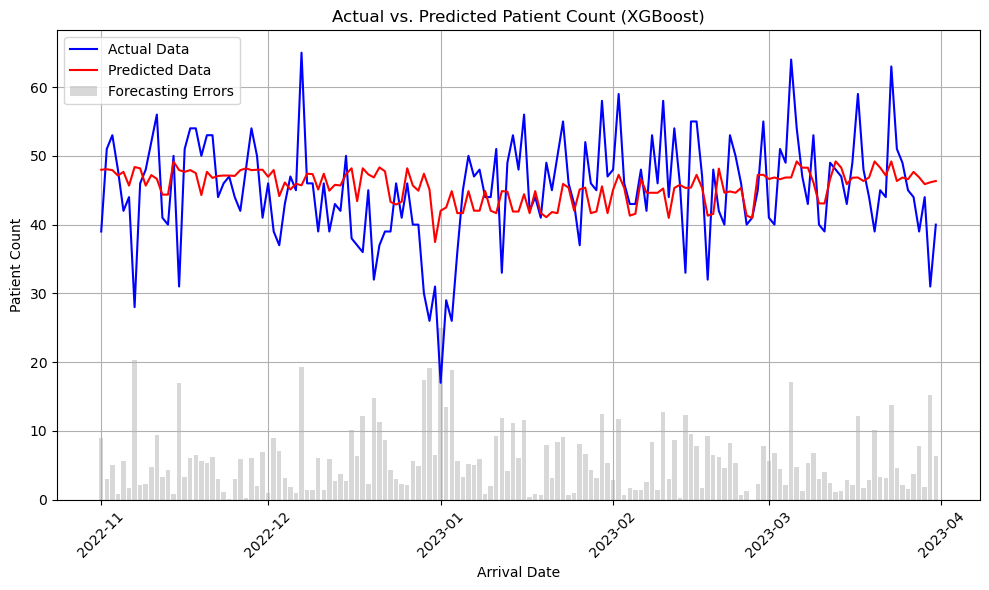

In [64]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","Season_Num","COVID_Status_Encoded","Month_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","Season_Num","COVID_Status_Encoded","Month_Encoded"]]
y_test = test_data['Patient_Count_Amb']

# Set up parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize XGBoost model
model = XGBRegressor()

# Create GridSearchCV instance
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions using the best model
predictions = best_model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (XGBoost)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# LSTM

Epoch 1/100
78/78 [==============================] - 2s 2ms/step - loss: 0.0525
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 8/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 9/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 11/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 12/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 13/100
78/78 [=================

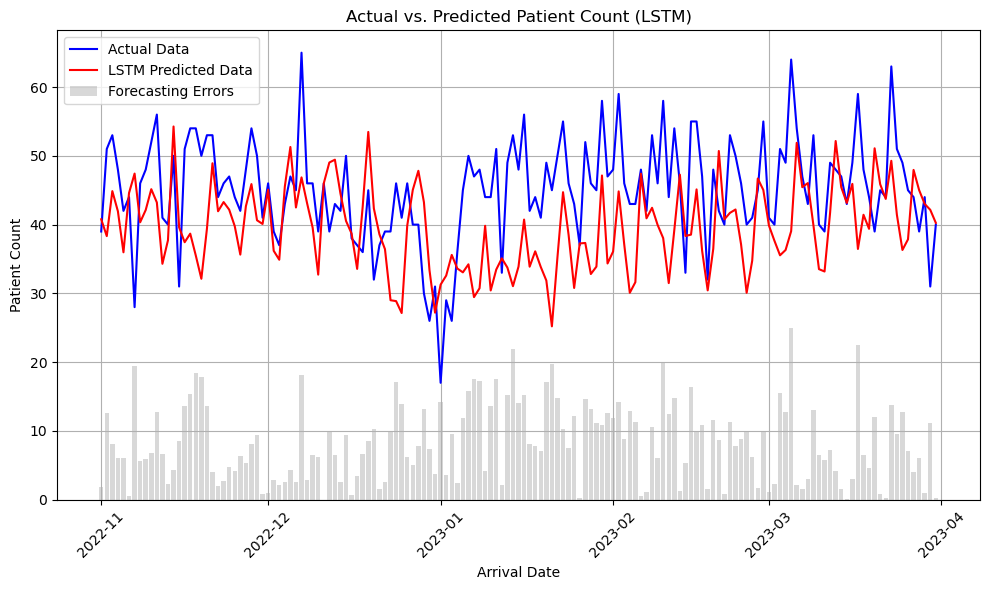

Mean Squared Error (MSE): 101.61668270198227
Mean Absolute Error (MAE): 8.330467944113623
Min Forecasting Error: 0.00434112548828125
Max Forecasting Error: 24.95071792602539
Mean Forecasting Error: 8.330467944113623
Standard Deviation: 5.6762651923670395
R-squared (R2): -0.771797583745305
Correlation: 0.24824024472246659


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Define the date range for training and testing
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test = test_data['Patient_Count_Amb']


# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])  # Reshape for LSTM
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])  # Reshape for LSTM

# Initialize and build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, shuffle=False)

# Forecasting using LSTM model
forecast_scaled = model.predict(X_test_scaled)
forecast = scaler.inverse_transform(forecast_scaled).flatten()

# Inverse transform the test data to the original scale
y_test = scaler.inverse_transform(y_test_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
correlation = np.corrcoef(y_test, forecast)[0, 1]
forecast_error = np.abs(y_test - forecast)
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Actual Data', color='blue')
plt.plot(test_data.index, forecast, label='LSTM Predicted Data', color='red')
plt.bar(test_data.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (LSTM)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Random Forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mean Squared Error (MSE): 57.174167493444244
Mean Absolute Error (MAE): 5.699895973665246
Min Forecasting Error: 0.013748673105503428
Max Forecasting Error: 28.438621608599597
Mean Forecasting Error: 5.699895973665246
Standard Deviation: 4.984969649395192
R-squared (R2): 0.003106093173441682
Correlation: 0.27002084794051506


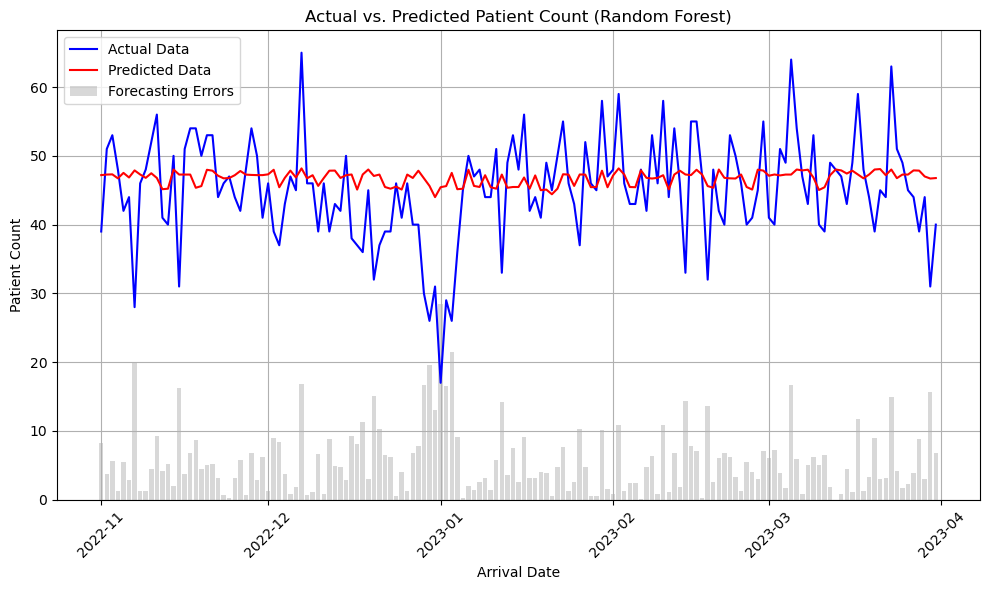

In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable
X_train = train_data[["Patient Count","Season_Num"]]
y_train = train_data['Patient_Count_Amb']
X_test = test_data[["Patient Count","Season_Num"]]
y_test = test_data['Patient_Count_Amb']

# Set up parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}

# Initialize Random Forest model
model = RandomForestRegressor()

# Create GridSearchCV instance
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions using the best model
predictions = best_model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(y_test, predictions_df['Predicted Patient Count'])
mae = mean_absolute_error(y_test, predictions_df['Predicted Patient Count'])
r2 = r2_score(y_test, predictions_df['Predicted Patient Count'])
correlation = y_test.corr(predictions_df['Predicted Patient Count'])

# Calculate statistics of forecasting error
forecast_error = np.abs(y_test - predictions_df['Predicted Patient Count'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)
print("Correlation:", correlation)

# Plot actual data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted Patient Count'], label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Predicted Patient Count (Random Forest)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'

train_data = sea_df[train_start:train_end]

# Extract features and target variable
X_train = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train = train_data['Patient_Count_Amb']

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Access feature importance scores
feature_importance = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
4            Season_Num    0.430488
0         Patient Count    0.351823
2         Month_Encoded    0.096558
3   Day_of_Week_Encoded    0.094599
5    Is_Weekend_Encoded    0.016738
1  COVID_Status_Encoded    0.009794


In [46]:
predictions_df

,Predicted Patient Count
Arrival Date,
2022-11-01,46.342614
2022-11-02,46.342614
2022-11-03,46.342614
2022-11-04,46.342614
2022-11-05,46.342614
...,...
2023-03-27,46.342614
2023-03-28,46.342614
2023-03-29,46.342614


# Ensemple

Epoch 1/100
78/78 [==============================] - 2s 2ms/step - loss: 0.0819
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 8/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 9/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 11/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 12/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 13/100
78/78 [=================

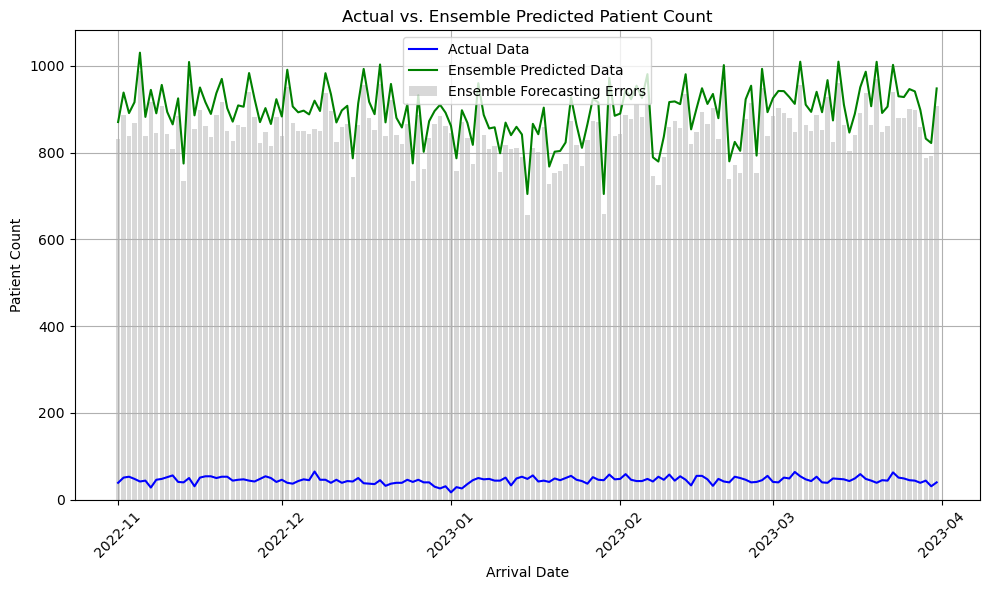

Ensemble Model - Mean Squared Error (MSE): 730671.1382045869
Ensemble Model - Mean Absolute Error (MAE): 852.6759360253558
Ensemble Model - Min Forecasting Error: 656.7020477879674
Ensemble Model - Max Forecasting Error: 988.3960509072515
Ensemble Model - Mean Forecasting Error: 852.6759360253558
Ensemble Model - Standard Deviation: 60.324004923878
Ensemble Model - R-squared (R2): -12739.047428827005
Ensemble Model - Correlation: 0.1591582976042403


In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit

# Load your data and set the index if not done already
# winter_daily_patient_count = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variable for Random Forest
X_train_rf = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train_rf = train_data['Patient_Count_Amb']
X_test_rf = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test_rf = test_data['Patient_Count_Amb']

# Extract features and target variable for LSTM
X_train_lstm = train_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_train_lstm = train_data['Patient_Count_Amb']
X_test_lstm = test_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded"]]
y_test_lstm = test_data['Patient_Count_Amb']

# Fit a Random Forest model
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train_rf, y_train_rf)

# Make predictions with Random Forest
predictions_rf = model_rf.predict(X_test_rf)

# Create a DataFrame for Random Forest predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df_rf = pd.DataFrame({'Arrival Date': prediction_dates, 'Predicted Patient Count (Random Forest)': predictions_rf})
predictions_df_rf.set_index('Arrival Date', inplace=True)

# Normalize the data for LSTM
scaler = MinMaxScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train_lstm)
y_train_scaled_lstm = scaler.fit_transform(y_train_lstm.values.reshape(-1, 1))
X_test_scaled_lstm = scaler.fit_transform(X_test_lstm)
y_test_scaled_lstm = scaler.fit_transform(y_test_lstm.values.reshape(-1, 1))

X_train_scaled_lstm = X_train_scaled_lstm.reshape(X_train_scaled_lstm.shape[0], 1, X_train_scaled_lstm.shape[1])
X_test_scaled_lstm = X_test_scaled_lstm.reshape(X_test_scaled_lstm.shape[0], 1, X_test_scaled_lstm.shape[1])

# Initialize and build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_scaled_lstm.shape[1], X_train_scaled_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model_lstm.fit(X_train_scaled_lstm, y_train_scaled_lstm, epochs=100, batch_size=32, shuffle=False)

# Forecasting using LSTM model
forecast_scaled_lstm = model_lstm.predict(X_test_scaled_lstm)
forecast_lstm = scaler.inverse_transform(forecast_scaled_lstm).flatten()

# Calculate metrics for Random Forest predictions
mse_rf = mean_squared_error(y_test_rf, predictions_rf)
mae_rf = mean_absolute_error(y_test_rf, predictions_rf)
r2_rf = r2_score(y_test_rf, predictions_rf)
correlation_rf = np.corrcoef(y_test_rf, predictions_rf)[0, 1]

# Calculate metrics for LSTM predictions
mse_lstm = mean_squared_error(y_test_lstm, forecast_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, forecast_lstm)
r2_lstm = r2_score(y_test_lstm, forecast_lstm)
correlation_lstm = np.corrcoef(y_test_lstm, forecast_lstm)[0, 1]

# Combine Random Forest and LSTM predictions using a weighted average
weight_rf = 0.7  # Adjust the weights based on your preference
weight_lstm = 0.3

# Scale the LSTM predictions to match the scale of Random Forest predictions
forecast_scaled_lstm = scaler.fit_transform(forecast_lstm.reshape(-1, 1))

# Calculate the ensemble predictions
ensemble_forecast_scaled = (weight_rf * predictions_rf.reshape(-1, 1)) + (weight_lstm * forecast_scaled_lstm)
ensemble_forecast = scaler.inverse_transform(ensemble_forecast_scaled).flatten()

# Calculate metrics for the ensemble predictions
ensemble_mse = mean_squared_error(y_test_lstm, ensemble_forecast)
ensemble_mae = mean_absolute_error(y_test_lstm, ensemble_forecast)
ensemble_r2 = r2_score(y_test_lstm, ensemble_forecast)
ensemble_correlation = np.corrcoef(y_test_lstm, ensemble_forecast)[0, 1]

# Calculate statistics of forecasting error for the ensemble
ensemble_forecast_error = np.abs(y_test_lstm - ensemble_forecast)
ensemble_min_error = ensemble_forecast_error.min()
ensemble_max_error = ensemble_forecast_error.max()
ensemble_mean_error = ensemble_forecast_error.mean()
ensemble_std_deviation = ensemble_forecast_error.std()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test_lstm, label='Actual Data', color='blue')
plt.plot(test_data.index, ensemble_forecast, label='Ensemble Predicted Data', color='green')
plt.bar(test_data.index, ensemble_forecast_error, label='Ensemble Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel('Patient Count')
plt.title('Actual vs. Ensemble Predicted Patient Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print metrics for the ensemble model
print("Ensemble Model - Mean Squared Error (MSE):", ensemble_mse)
print("Ensemble Model - Mean Absolute Error (MAE):", ensemble_mae)
print("Ensemble Model - Min Forecasting Error:", ensemble_min_error)
print("Ensemble Model - Max Forecasting Error:", ensemble_max_error)
print("Ensemble Model - Mean Forecasting Error:", ensemble_mean_error)
print("Ensemble Model - Standard Deviation:", ensemble_std_deviation)
print("Ensemble Model - R-squared (R2):", ensemble_r2)
print("Ensemble Model - Correlation:", ensemble_correlation)

# Sig diff test

In [61]:
df_sig = combined_df[["Patient Count",'Day_of_Week','Month','COVID_Status','Season']]

In [62]:
df_sig

,Patient Count,Day_of_Week,Month,COVID_Status
Ambulance Arrival Date,,,,
2009-02-12,40,Thursday,February,No
2009-02-13,54,Friday,February,No
2009-02-14,20,Saturday,February,No
2009-02-15,38,Sunday,February,No
2009-02-16,45,Monday,February,No
...,...,...,...,...
2023-03-27,44,Monday,March,No
2023-03-28,39,Tuesday,March,No
2023-03-29,44,Wednesday,March,No


In [63]:
import pandas as pd
from scipy.stats import f_oneway, kruskal, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

# Load your DataFrame (assuming it's already loaded)
# df_sig = pd.read_csv("your_dataframe.csv")

# Step 1: Frequency Analysis and Visualization
avg_patient_count_by_day = df_sig.groupby("Day_of_Week")["Patient Count"].mean()
avg_patient_count_by_month = df_sig.groupby("Month")["Patient Count"].mean()

# Step 2: ANOVA/Kruskal-Wallis for Day_of_Week and Month
anova_day = f_oneway(*[group["Patient Count"] for name, group in df_sig.groupby("Day_of_Week")])
kruskal_day = kruskal(*[group["Patient Count"] for name, group in df_sig.groupby("Day_of_Week")])

anova_month = f_oneway(*[group["Patient Count"] for name, group in df_sig.groupby("Month")])
kruskal_month = kruskal(*[group["Patient Count"] for name, group in df_sig.groupby("Month")])

# Step 3: Chi-Square Test for COVID_Status
chi2, p, _, _ = chi2_contingency(pd.crosstab(df_sig["COVID_Status"], df_sig["Patient Count"] > 0))

# Print results
print("Average Patient Count by Day of Week:\n", avg_patient_count_by_day)
print("Average Patient Count by Month:\n", avg_patient_count_by_month)

print("\nANOVA Test for Day of Week:\n", anova_day)
print("Kruskal-Wallis Test for Day of Week:\n", kruskal_day)

print("\nANOVA Test for Month:\n", anova_month)
print("Kruskal-Wallis Test for Month:\n", kruskal_month)

print("\nChi-Square Test for COVID_Status:\n", chi2, p)

# Step 4: Post-Hoc Analysis (Tukey's HSD for ANOVA)
if anova_day.pvalue < 0.05:
    tukey_day = pairwise_tukeyhsd(df_sig["Patient Count"], df_sig["Day_of_Week"])
    print("\nTukey's HSD for Day of Week:\n", tukey_day)

# Step 5: Perform T-Test for COVID_Status
covid_yes = df_sig[df_sig["COVID_Status"] == "Yes"]["Patient Count"]
covid_no = df_sig[df_sig["COVID_Status"] == "No"]["Patient Count"]

t_stat, t_p_value = ttest_ind(covid_yes, covid_no)
print("\nT-Test for COVID_Status:\n", t_stat, t_p_value)

Average Patient Count by Day of Week:
 Day_of_Week
Friday       53.433962
Monday       55.291105
Saturday     51.182796
Sunday       52.247978
Thursday     52.231183
Tuesday      50.642473
Wednesday    52.005405
Name: Patient Count, dtype: float64
Average Patient Count by Month:
 Month
December    53.700461
February    51.592233
January     52.251152
March       51.215054
November    53.700000
October     52.221198
Name: Patient Count, dtype: float64

ANOVA Test for Day of Week:
 F_onewayResult(statistic=9.812316332231696, pvalue=1.0149321819641427e-10)
Kruskal-Wallis Test for Day of Week:
 KruskalResult(statistic=51.55420879077925, pvalue=2.2921778254750217e-09)

ANOVA Test for Month:
 F_onewayResult(statistic=5.2662961334985, pvalue=8.110596492776683e-05)
Kruskal-Wallis Test for Month:
 KruskalResult(statistic=23.50469701486891, pvalue=0.00027023778788616174)

Chi-Square Test for COVID_Status:
 0.0 1.0

Tukey's HSD for Day of Week:
    Multiple Comparison of Means - Tukey HSD, FWER=0

In [58]:
sea_df

,Patient Count,Patient_Count_Amb,COVID_Status_Encoded,Month_Encoded,Day_of_Week_Encoded,Season_Num,Is_Weekend_Encoded
Arrival Date,,,,,,,
2009-01-01,191,52,0,0,4,0,1
2009-01-02,204,46,0,0,5,0,1
2009-01-03,175,41,0,0,6,0,0
2009-01-04,159,27,0,0,0,0,0
2009-01-05,179,44,0,0,1,0,1
...,...,...,...,...,...,...,...
2023-03-27,342,44,0,2,1,14,1
2023-03-28,324,39,0,2,2,14,1
2023-03-29,313,44,0,2,3,14,1
